In [1]:
#import what may be needed:

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix # used for evaluation and confusion matrix.
import seaborn as sns #used for plotting
from skorch import NeuralNetClassifier # used for hyper parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
# Define transformations for Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalizes with mean and std for one channel (grayscale)
])

# Load the Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

what we have done so far, is download and set the data from Fashion MNIST into a training dataset and a test dataset.
weve also set the transform to normalize for grayscale.

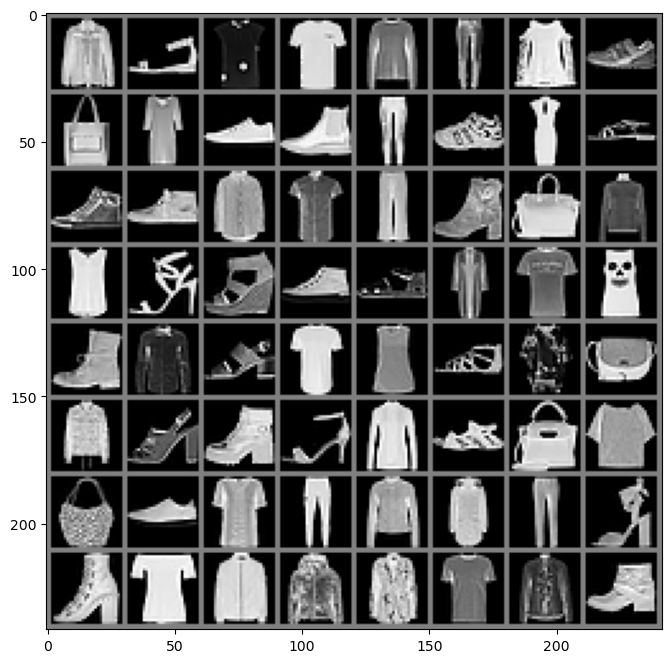

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    # For grayscale images, we directly display the image with cmap='gray'
    plt.imshow(npimg[0], cmap='gray')  # img[0] to handle the single-channel image (C, H, W)
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader) 
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# - `img = img / 2 + 0.5` reverses the normalization to bring pixel values back to [0, 1] range for visualization.
# - `npimg[0]` accesses the first channel for grayscale images, and `cmap='gray'` ensures proper display.


here we quickly show a batch of our training data, so we have a better idea as to what were using to train, and what we want to identify.
next, we edit the code from the example we were given so that we can later visualize the weights.

In [5]:
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 1 input channel (grayscale)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)  #add dropout layer
        # Adjusting the fully connected layer for the new output size after conv layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  #7x7 due to the smaller image size
        self.fc2 = nn.Linear(512, 10)  # 10 classes for Fashion-MNIST

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + pooling
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output of the conv layers
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))  # FC1
        x = self.fc2(x)  # FC2 
        return x

# Conv1 (First Convolutional Layer)
conv1_output_channels = 32  # Number of output channels
conv1_input_channels = 1    # Number of input channels (grayscale image)
conv1_kernel_size = 3       # Kernel size is 3x3
conv1_biases = conv1_output_channels  # One bias per output channel

# Formula: (Output Channels x Input Channels x Kernel Height x Kernel Width) + Biases
conv1_weights = conv1_output_channels * conv1_input_channels * conv1_kernel_size * conv1_kernel_size
conv1_total_weights = conv1_weights + conv1_biases  # Total weights for Conv1

# Conv2 (Second Convolutional Layer)
conv2_output_channels = 64  # Number of output channels
conv2_input_channels = 32   # Number of input channels (from Conv1 output)
conv2_kernel_size = 3       # Kernel size is 3x3
conv2_biases = conv2_output_channels  # One bias per output channel

# Formula: (Output Channels x Input Channels x Kernel Height x Kernel Width) + Biases
conv2_weights = conv2_output_channels * conv2_input_channels * conv2_kernel_size * conv2_kernel_size
conv2_total_weights = conv2_weights + conv2_biases  # Total weights for Conv2

# FC1 (First Fully Connected Layer)
fc1_input_neurons = 64 * 7 * 7  # Input neurons (from Conv2 output size)
fc1_output_neurons = 512        # Number of output neurons
fc1_biases = fc1_output_neurons # One bias per output neuron

# Formula: (Output Neurons x Input Neurons) + Biases
fc1_weights = fc1_output_neurons * fc1_input_neurons
fc1_total_weights = fc1_weights + fc1_biases  # Total weights for FC1

# FC2 (Second Fully Connected Layer)
fc2_input_neurons = 512   # Input neurons (from FC1 output)
fc2_output_neurons = 10   # Number of output neurons (number of classes)
fc2_biases = fc2_output_neurons  # One bias per output neuron

# Formula: (Output Neurons x Input Neurons) + Biases
fc2_weights = fc2_output_neurons * fc2_input_neurons
fc2_total_weights = fc2_weights + fc2_biases  # Total weights for FC2

# Total Weights
total_weights = conv1_total_weights + conv2_total_weights + fc1_total_weights + fc2_total_weights

# Results
weights = {
    "Conv1 Weights": conv1_total_weights,
    "Conv2 Weights": conv2_total_weights,
    "FC1 Weights": fc1_total_weights,
    "FC2 Weights": fc2_total_weights,
    "Total Weights": total_weights
}
print(f"Weights: {weights}")


Weights: {'Conv1 Weights': 320, 'Conv2 Weights': 18496, 'FC1 Weights': 1606144, 'FC2 Weights': 5130, 'Total Weights': 1630090}


the reason we use 64*7*7 is that the original input size of 28x28 is reduced through convolution and pooling operations.
After the first convolution and pooling layer, the spatial dimensions become 14x14, and after the second convolution and pooling, they are reduced to 7x7. Therefore, the output feature map has a size of 64 channels, each of size 7x7, resulting in a flattened input of 64 * 7 * 7 for the fully connected layer.

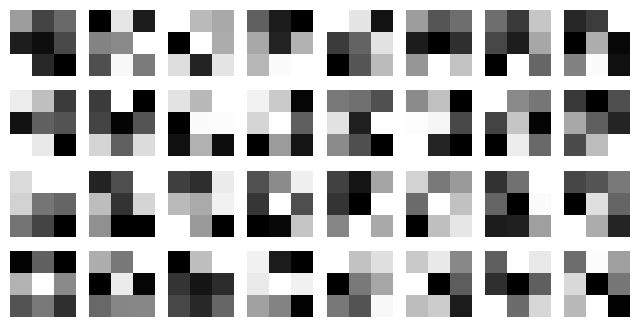

In [6]:

def visualize_filters(layer):
    filters = layer.weight.data.clone().cpu()
    # Normalize filters to be in the range [0, 1]
    filters = filters - filters.min()
    filters = filters / filters.max()
    # The code above shifts all filter values so the minimum becomes 0,
    # and then scales them by dividing by the new maximum value.
    # This results in all values being mapped to the [0, 1] range.

    filter_num = filters.shape[0]  # Number of filters
    n_columns = 8  # Number of columns for visualization
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)
    
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))
    
    # Iterate over filters and plot them
    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(filters[i][0], cmap='gray')  # Use only the first channel for grayscale
        axs[row, col].axis('off')
    plt.show()
    
model = CNN()
visualize_filters(model.conv1)

The graph in the image shows the filters (also called kernels) from the first convolutional layer of our CNN.
These filters are still at their initial, untrained state, meaning they have not yet learned to detect meaningful features from the data. 
The grayscale patterns we see are weights that will eventually adapt during training to detect edges, textures, or simple patterns. 
Once trained, they will act like pattern detectors, helping the network extract useful information from clothing images such as outlines or textures.

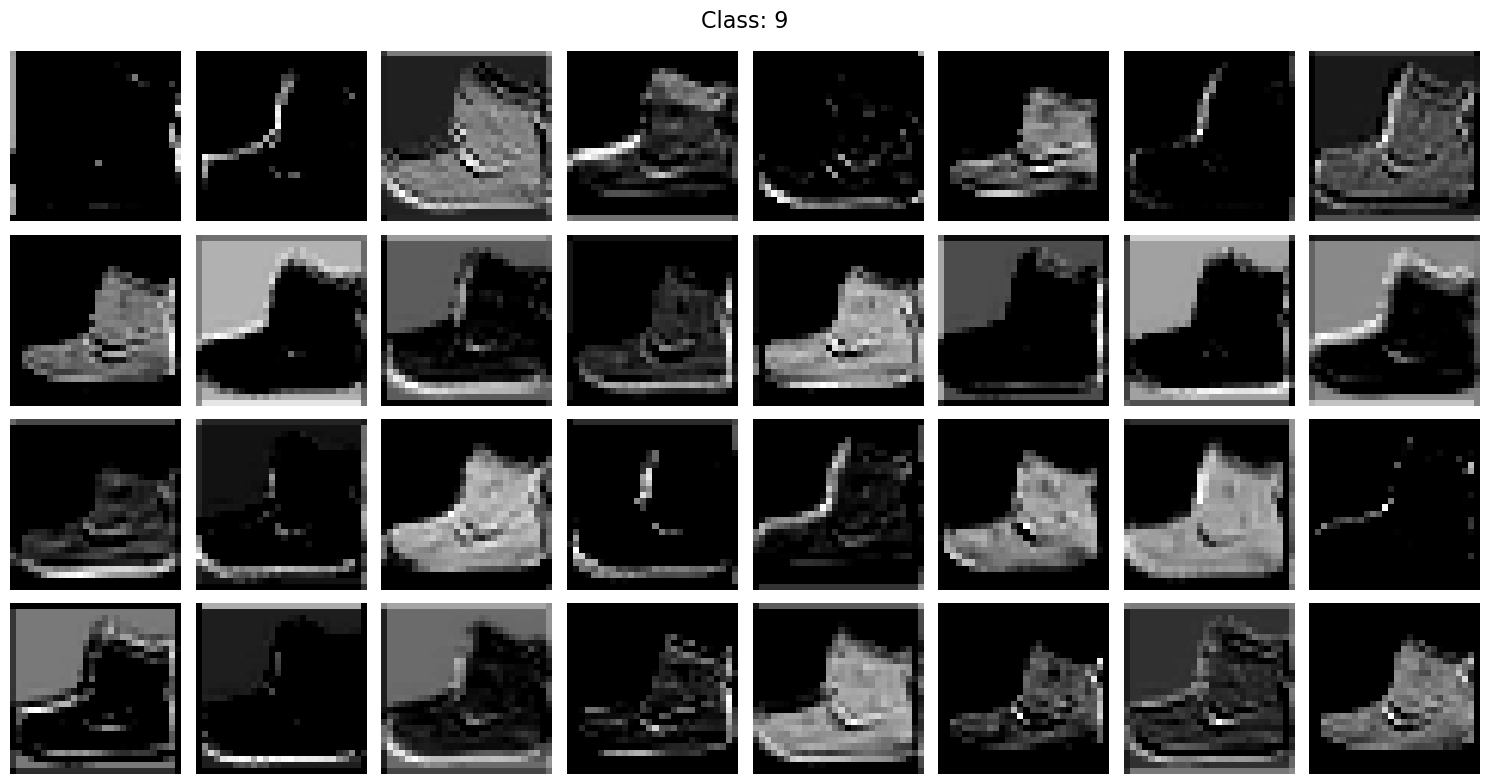

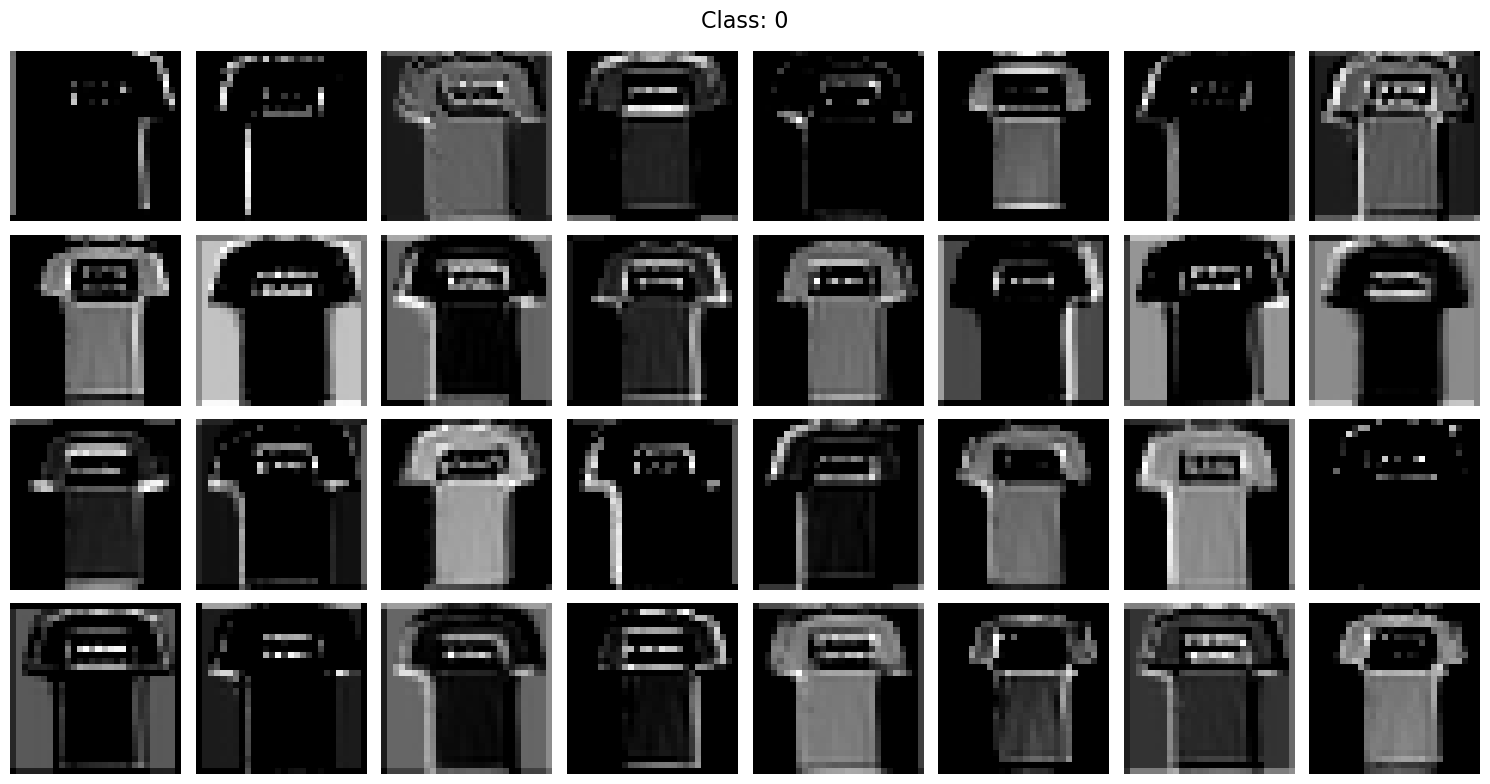

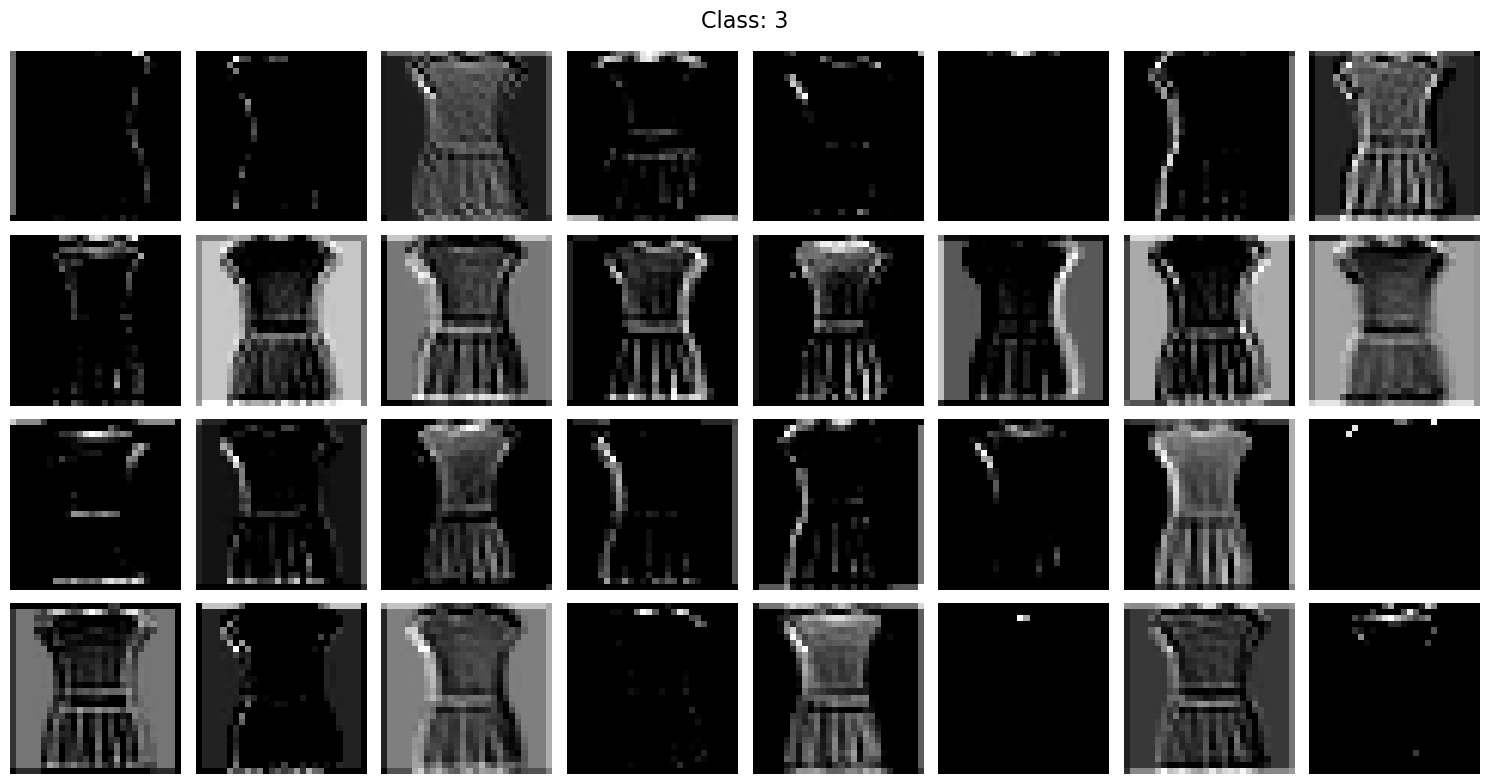

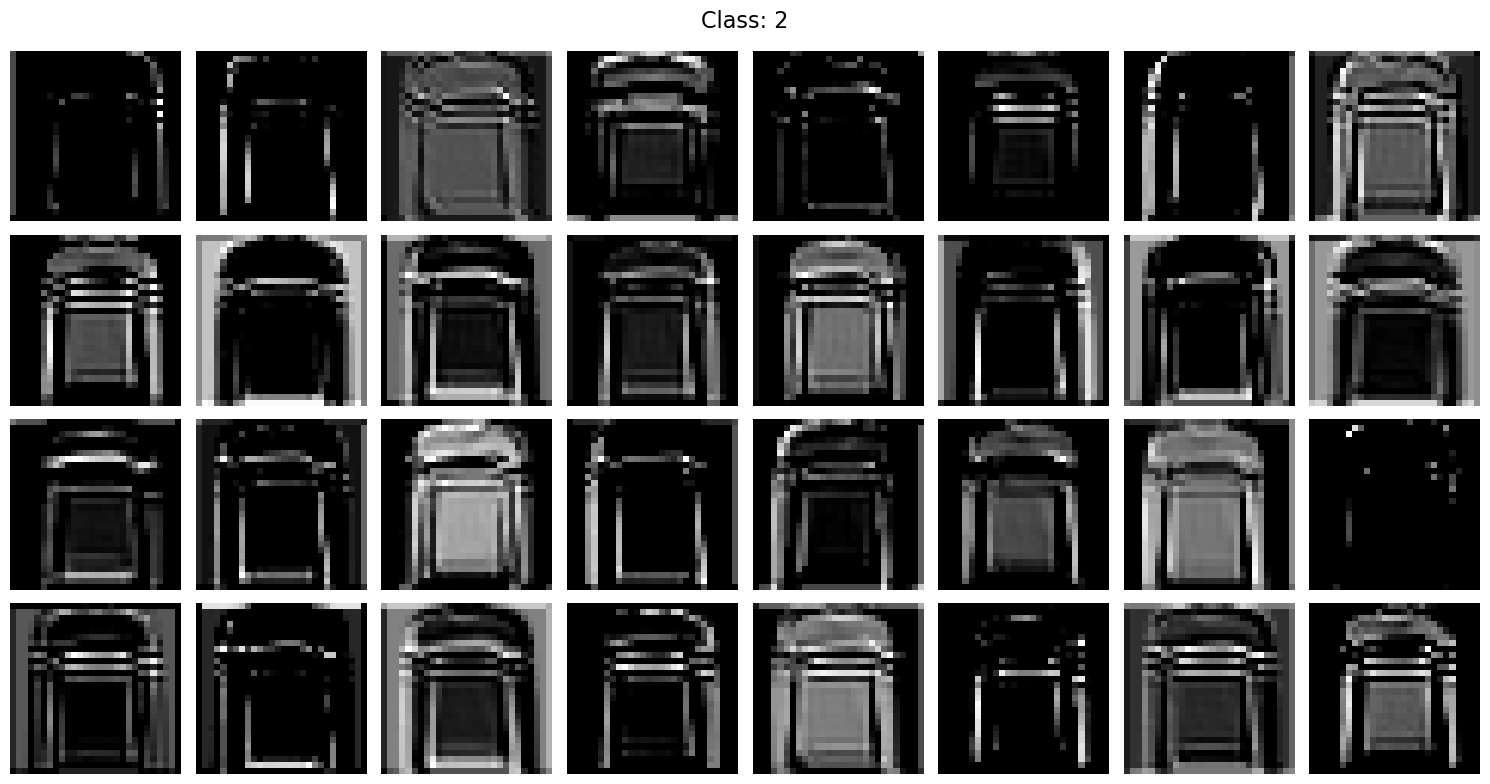

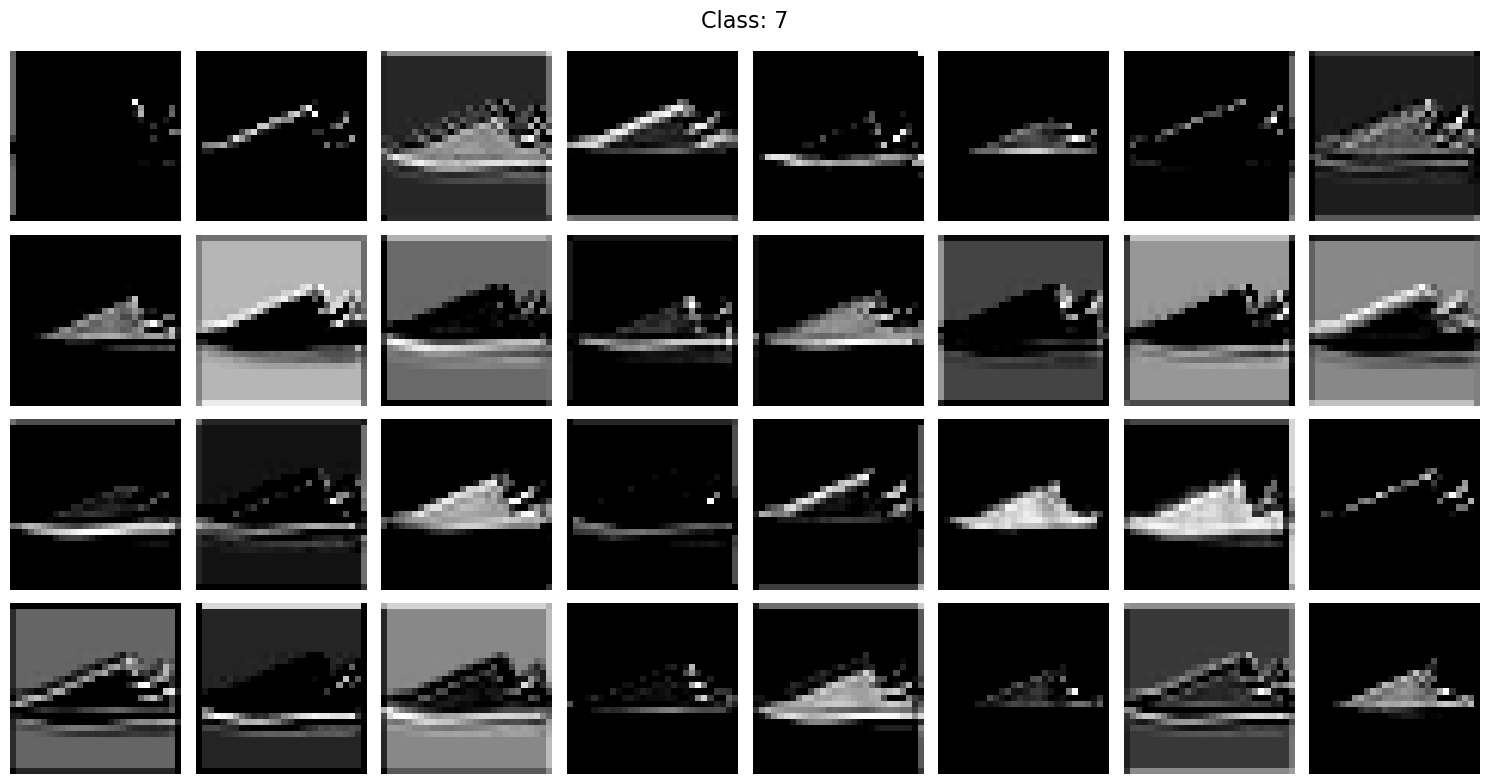

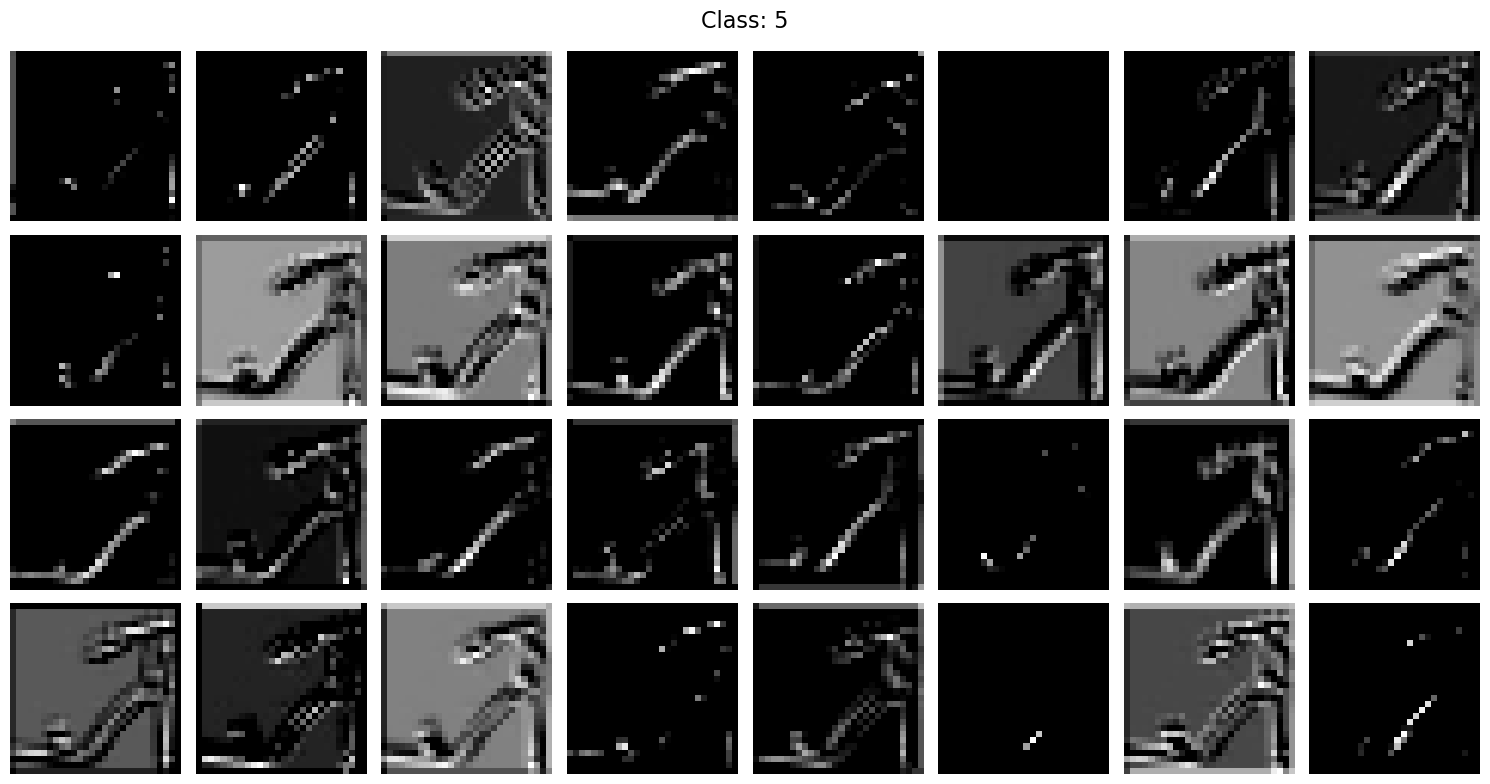

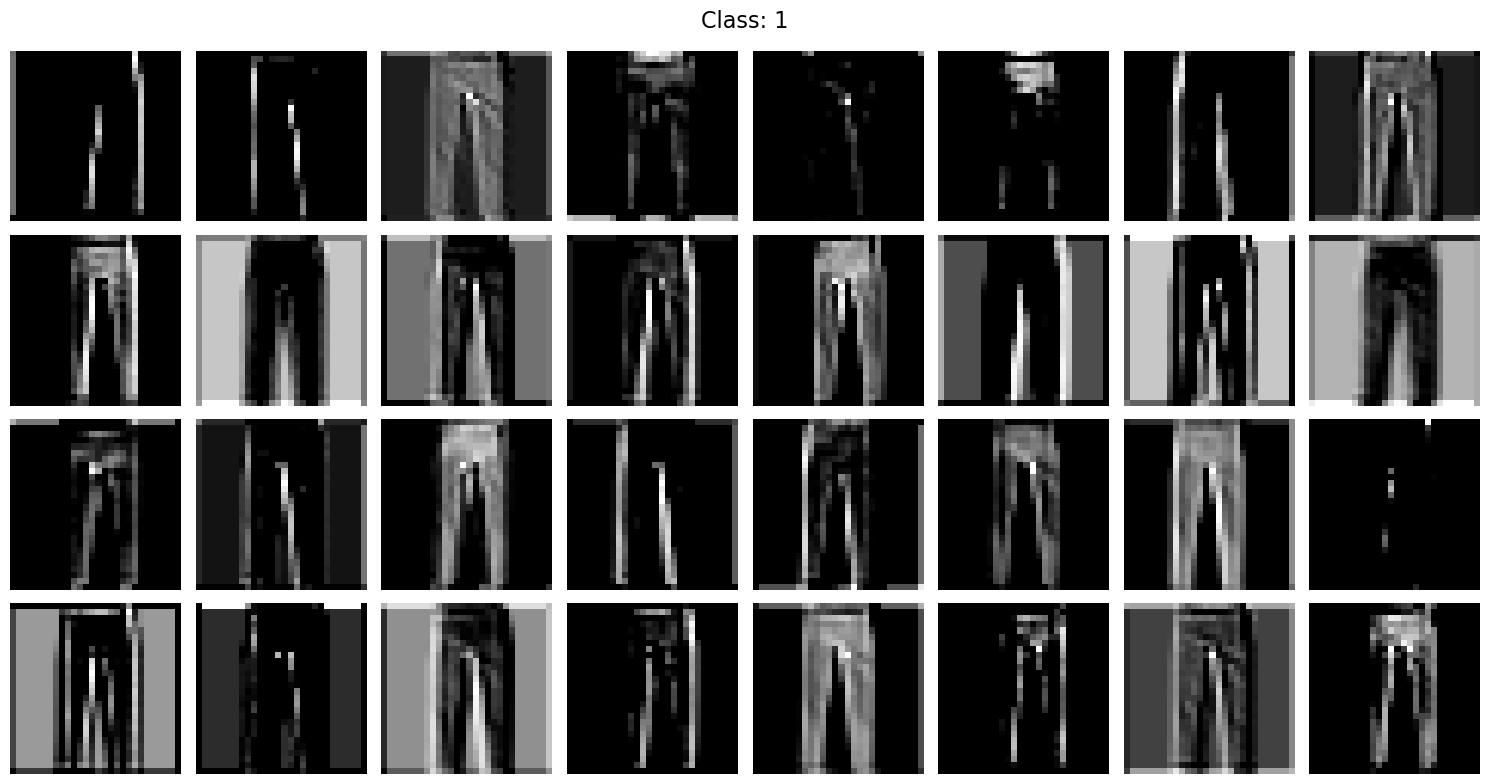

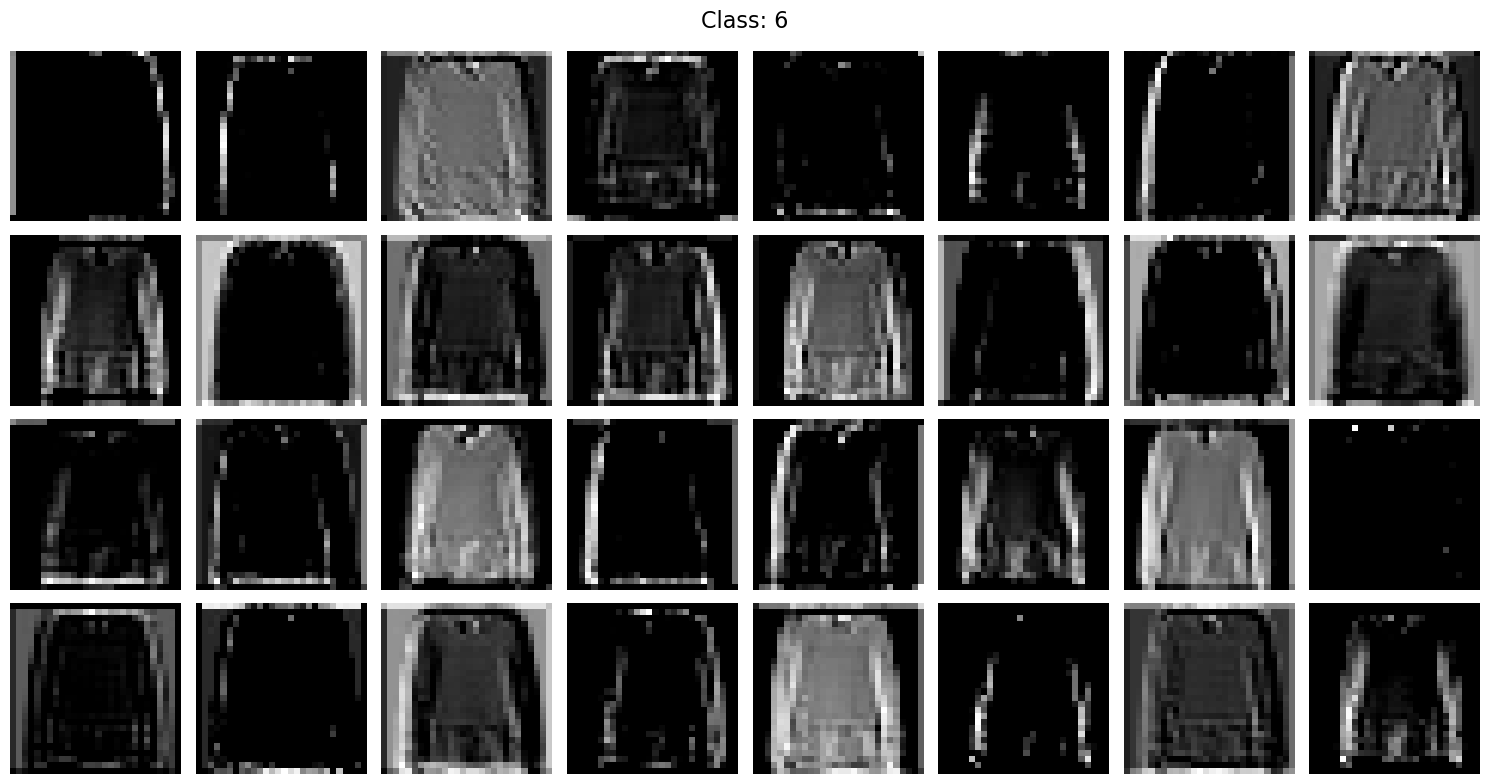

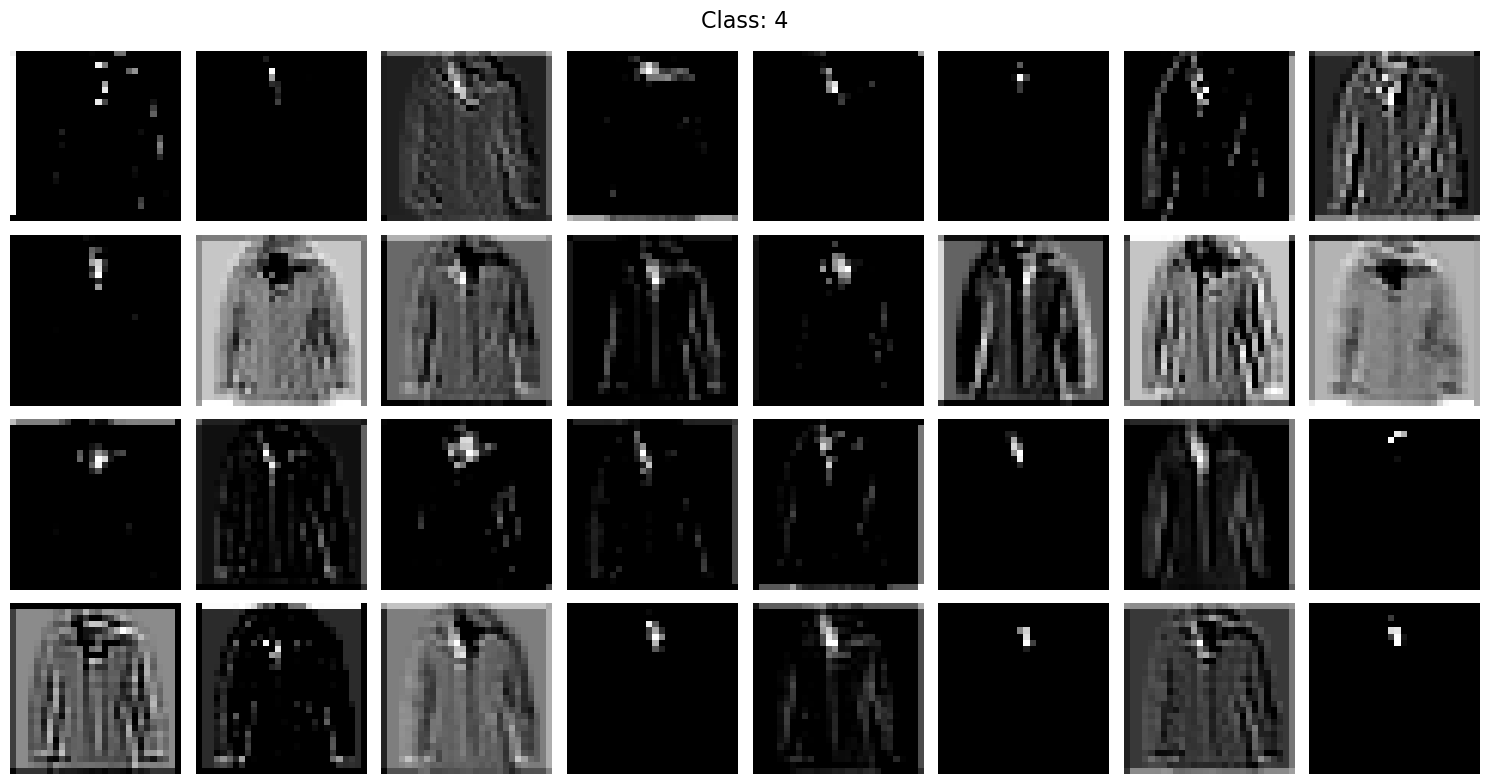

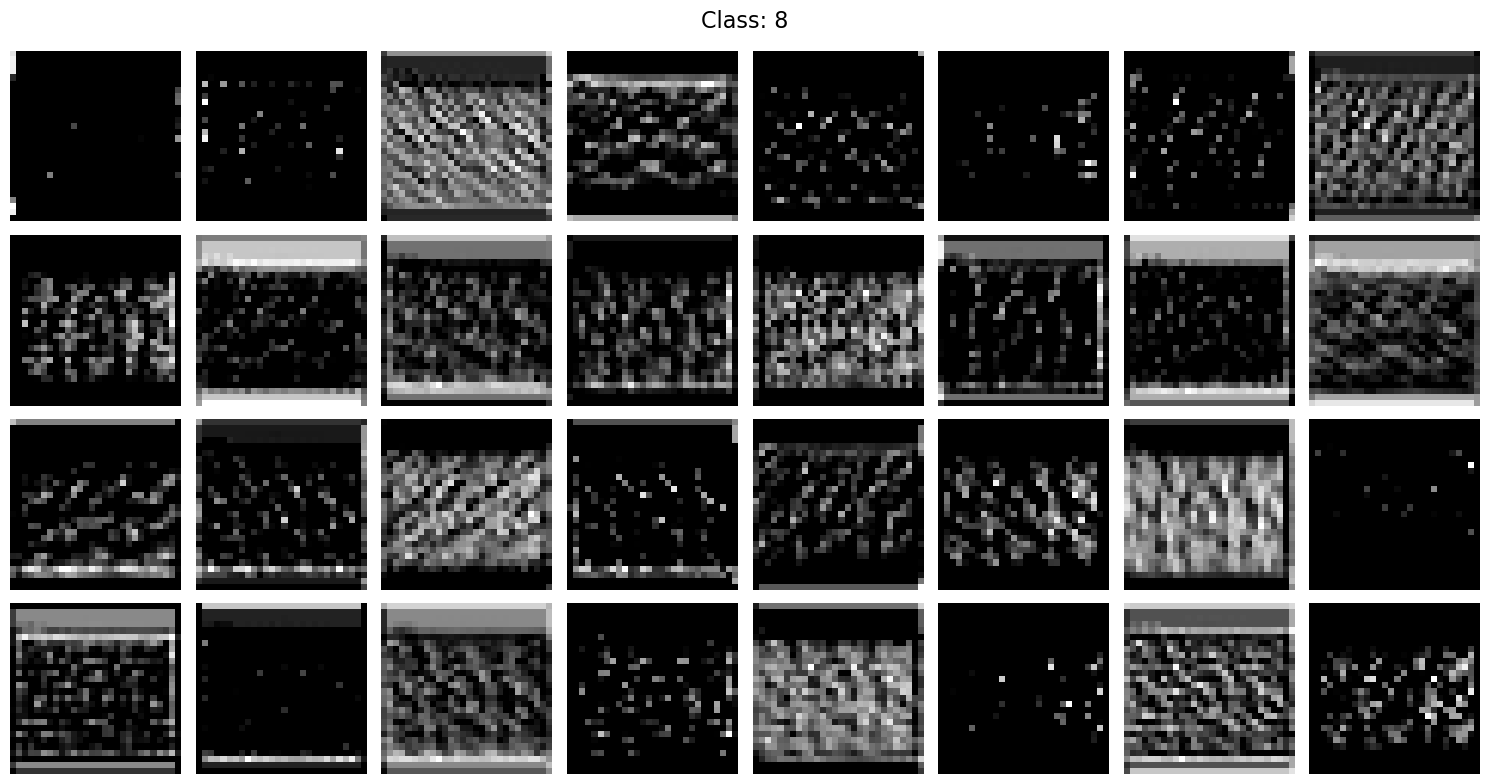

In [7]:
# Visualize feature maps for one image of each class in Fashion-MNIST
def visualize_feature_maps_per_class(dataset, model):
    model.eval()  # Set the model to evaluation mode
    class_seen = set()  # Track which classes have already been visualized

    # Loop through the dataset to find one image from each class
    for image, label in dataset:
        if label not in class_seen:
            class_seen.add(label)  # Mark this class as seen

            # Prepare the image for the model (add batch dimension, move to device)
            image_input = image.unsqueeze(0).to(next(model.parameters()).device)

            # Forward pass through the first convolutional layer and activation
            with torch.no_grad():  # Disable gradient tracking
                x = model.conv1(image_input)  # Apply first conv layer
                x = torch.relu(x)  # Apply ReLU activation

            # Remove the batch dimension and move data to CPU for visualization
            feature_maps = x.squeeze(0).cpu()

            # Set up the number of rows and columns for plotting the feature maps
            num_maps = feature_maps.shape[0]  # Number of feature maps
            n_columns = 8
            n_rows = num_maps // n_columns + (num_maps % n_columns > 0)

            # Create a grid of subplots to display the feature maps
            fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
            for i in range(num_maps):
                row = i // n_columns
                col = i % n_columns
                axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')  # Show each feature map in grayscale
                axs[row, col].axis('off')  # Hide axis ticks

            # Add a title showing which class is being visualized
            plt.suptitle(f'Class: {label}', fontsize=16)
            plt.tight_layout()
            plt.show()  # Show the plot

        # Stop once we've shown one image from all 10 classes
        if len(class_seen) == 10:
            break

# Call the function to visualize feature maps
visualize_feature_maps_per_class(train_dataset, model)


This output shows the feature maps from the first convolutional layer of our CNN, highlighting how different filters respond to parts of the input image.
Some filters activate strongly on specific features like edges, or specific textures, while others stay mostly dark, indicating selectivity to different patterns.
Overall, it goes to show that the network is starting to learn features to distinguish clothing types.

Epoch 1/13, Train Loss: 0.5258, Val Loss: 0.3693, LR: 0.001000
Epoch 3/13, Train Loss: 0.3094, Val Loss: 0.2745, LR: 0.001000
Epoch 5/13, Train Loss: 0.2640, Val Loss: 0.2515, LR: 0.001000
Epoch 7/13, Train Loss: 0.2386, Val Loss: 0.2399, LR: 0.001000
Epoch 9/13, Train Loss: 0.2206, Val Loss: 0.2533, LR: 0.001000
Epoch 11/13, Train Loss: 0.2107, Val Loss: 0.2250, LR: 0.001000
Epoch 13/13, Train Loss: 0.1956, Val Loss: 0.2234, LR: 0.001000


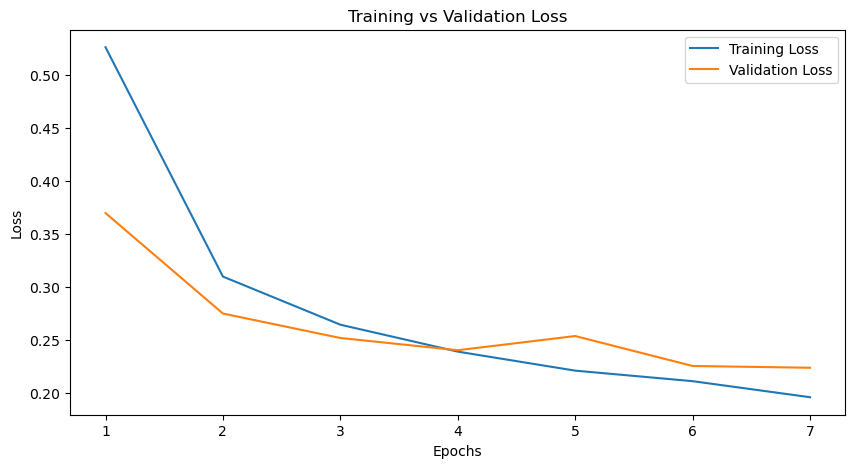

In [8]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations for Fashion-MNIST
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),       # Randomly flip image for augmentation
    transforms.RandomRotation(15),           # Rotate image slightly
    transforms.ToTensor(),                   # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))     # Normalize grayscale image (1 channel)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),                   # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))     # Normalize grayscale image
])

# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)    # No shuffle for testing

# CNN Model for Fashion-MNIST
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input channels = 1 for grayscale
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)                                # Dropout to prevent overfitting
        self.fc1 = nn.Linear(64 * 7 * 7, 512)                              # Flattened size is 64 x 7 x 7
        self.fc2 = nn.Linear(512, 10)                                      # 10 output classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))   # Conv1 + ReLU + Pool
        x = self.pool(torch.relu(self.conv2(x)))   # Conv2 + ReLU + Pool
        x = x.view(x.size(0), -1)                  # Flatten the output
        x = self.dropout(torch.relu(self.fc1(x)))  # FC1 + ReLU + Dropout
        x = self.fc2(x)                            # Final FC layer
        return x

# Initialize model and training tools
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()                     # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)  # LR scheduler

# Training loop
num_epochs = 13
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()              # Clear gradients
        outputs = model(inputs)            # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update weights
        running_loss += loss.item()

    # Validation every 2 epochs
    if epoch % 2 == 0:
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        model.eval()  # Set model to eval mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device) # Move data to device
                outputs = model(inputs) # Forward pass
                loss = criterion(outputs, labels) # Calculate loss
                val_loss += loss.item() # Accumulate loss
        val_loss = val_loss / len(test_loader) # Average validation loss
        val_losses.append(val_loss) # Save validation loss for plotting

        # Step learning rate scheduler
        scheduler.step(val_loss)
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs_recorded = range(1, len(train_losses) + 1)
plt.plot(epochs_recorded, train_losses, label='Training Loss')
plt.plot(epochs_recorded, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

after running the model over 40 epochs, we saw that around epoch 13 we got the lowest validation loss, and while the training loss kept going down after that, we can understand from that that after epoch 15, due to the validation loss starting to go up, that we begin overfitting to our trianing data. 
so, taking that into consideration, well go up to 14 epochs at most, at least untill we do hyper-parameter tuning later on.
This also highlights the importance of evaluating the model not just on how well it performs on the training set, but on how well it generalizes to unseen data.
The validation loss provides a good signal for this, and watching it helps us avoid training for too long. Going forward, we can add early stopping to automatically halt training when the validation loss stops improving, which would save time and help prevent overfitting even more effectively.

Epoch 1/50, Train Loss: 0.5407, Val Loss: 0.3967, LR: 0.001000
Epoch 3/50, Train Loss: 0.3242, Val Loss: 0.2867, LR: 0.001000
Epoch 5/50, Train Loss: 0.2737, Val Loss: 0.2466, LR: 0.001000
Epoch 7/50, Train Loss: 0.2467, Val Loss: 0.2353, LR: 0.001000
Epoch 9/50, Train Loss: 0.2289, Val Loss: 0.2269, LR: 0.001000
Epoch 11/50, Train Loss: 0.2163, Val Loss: 0.2289, LR: 0.001000
Epoch 13/50, Train Loss: 0.2043, Val Loss: 0.2368, LR: 0.001000
Epoch 15/50, Train Loss: 0.1945, Val Loss: 0.2211, LR: 0.001000
Epoch 17/50, Train Loss: 0.1867, Val Loss: 0.2392, LR: 0.001000
Epoch 19/50, Train Loss: 0.1802, Val Loss: 0.2174, LR: 0.001000
Epoch 21/50, Train Loss: 0.1749, Val Loss: 0.2271, LR: 0.001000
Epoch 23/50, Train Loss: 0.1689, Val Loss: 0.2196, LR: 0.001000
Epoch 25/50, Train Loss: 0.1621, Val Loss: 0.2206, LR: 0.001000
Epoch 27/50, Train Loss: 0.1591, Val Loss: 0.2352, LR: 0.000100
Early stopping triggered at epoch 27


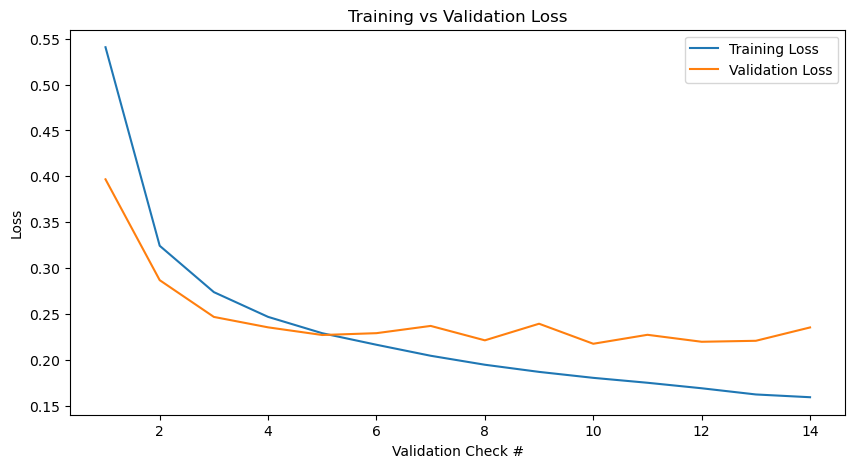

In [9]:
# Initialize model and training tools
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()                     # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)  # LR scheduler

# Training loop with early stopping
num_epochs = 50
train_losses = []
val_losses = []

# Early stopping parameters
early_stop_patience = 4  # Number of validation checks with no improvement allowed
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()              # Clear gradients
        outputs = model(inputs)            # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update weights
        running_loss += loss.item()

    # Validation every 2 epochs
    if epoch % 2 == 0:
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss = val_loss / len(test_loader)
        val_losses.append(val_loss)

        # Step learning rate scheduler
        scheduler.step(val_loss)
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1  # No improvement

        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break  # Stop training

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Validation Check #')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


As we can see above, our early stop triggered at epoch 27, but i still believe it is better to stop at around epoch 13-15, as to prevent overfitting
##to note, the thought before this is wrong, but has been left in to show the tests i have done.
its actually better to let it run untill epoch 27 and then stop, as the accuracy test jumps up by 1%. while its a minor imporvement, it is an improvement never the less.##

In [10]:
# Initialize counters and storage for predictions and true labels
correct = 0           # count correct predictions
total = 0             # count total samples
all_preds = []        # store all predicted labels
all_labels = []       # store all true labels

model.eval()  # Set model to evaluation mode (important for dropout, batchnorm, etc.)
with torch.no_grad():  # Disable gradient tracking for evaluation 
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU

        outputs = model(inputs)                 # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class index (ignore max score)

        total += labels.size(0)                    # Add batch size to total
        correct += (predicted == labels).sum().item()  # Count correct predictions

        # Store predictions and true labels for later metric evaluation
        all_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())    # Same for true labels

# Calculate overall accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Print detailed classification metrics: precision, recall, F1-score for each class
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


Test Accuracy: 92.64%

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.91      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.83      0.93      0.88      1000
       Dress       0.93      0.92      0.93      1000
        Coat       0.88      0.89      0.88      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.85      0.72      0.78      1000
     Sneaker       0.94      0.99      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



explanation for this is in the next cell.

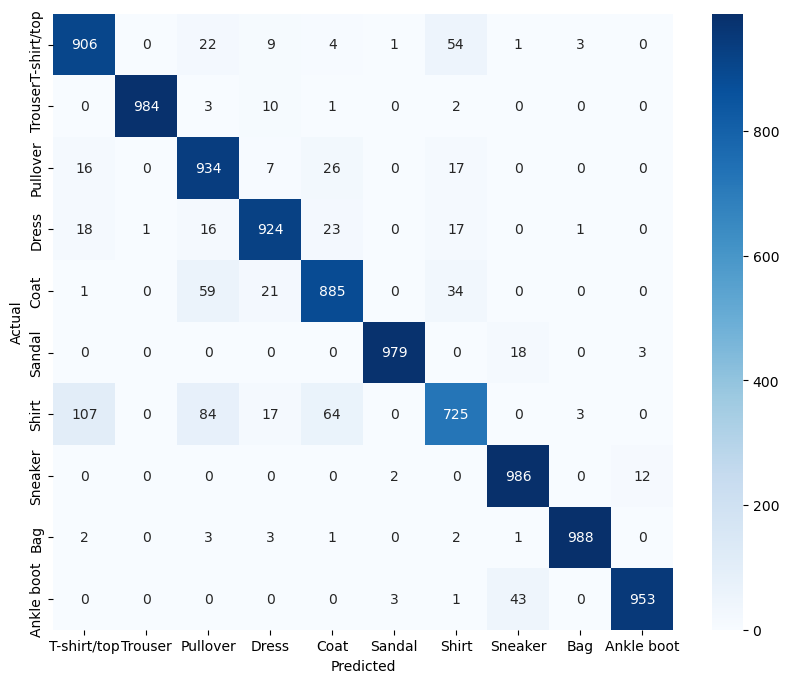

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The results show that the model performs very well on the Fashion-MNIST dataset, achieving an overall accuracy of 92.75%.
Most classes have high precision, recall, and F1-scores, especially for items like Sneakers, Ankle boots, and Trousers, which are likely easier to distinguish due to their distinct features.
However, the model struggles slightly with more visually similar classes such as Shirts and T-shirts/tops, where the F1-scores are comparatively lower. with Shirts being its least accurate class.
This suggests that while the model is generally robust, there's room for improvement in distinguishing subtle clothing differences—possibly by refining the model architecture or tuning hyperparameters.

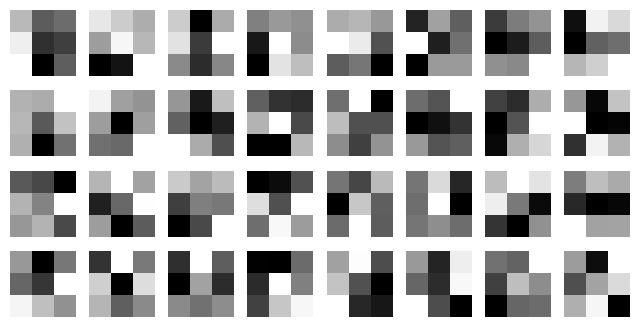

In [12]:
visualize_filters(model.conv1)

we can see from the visualization the way different weights the kernel has after training.

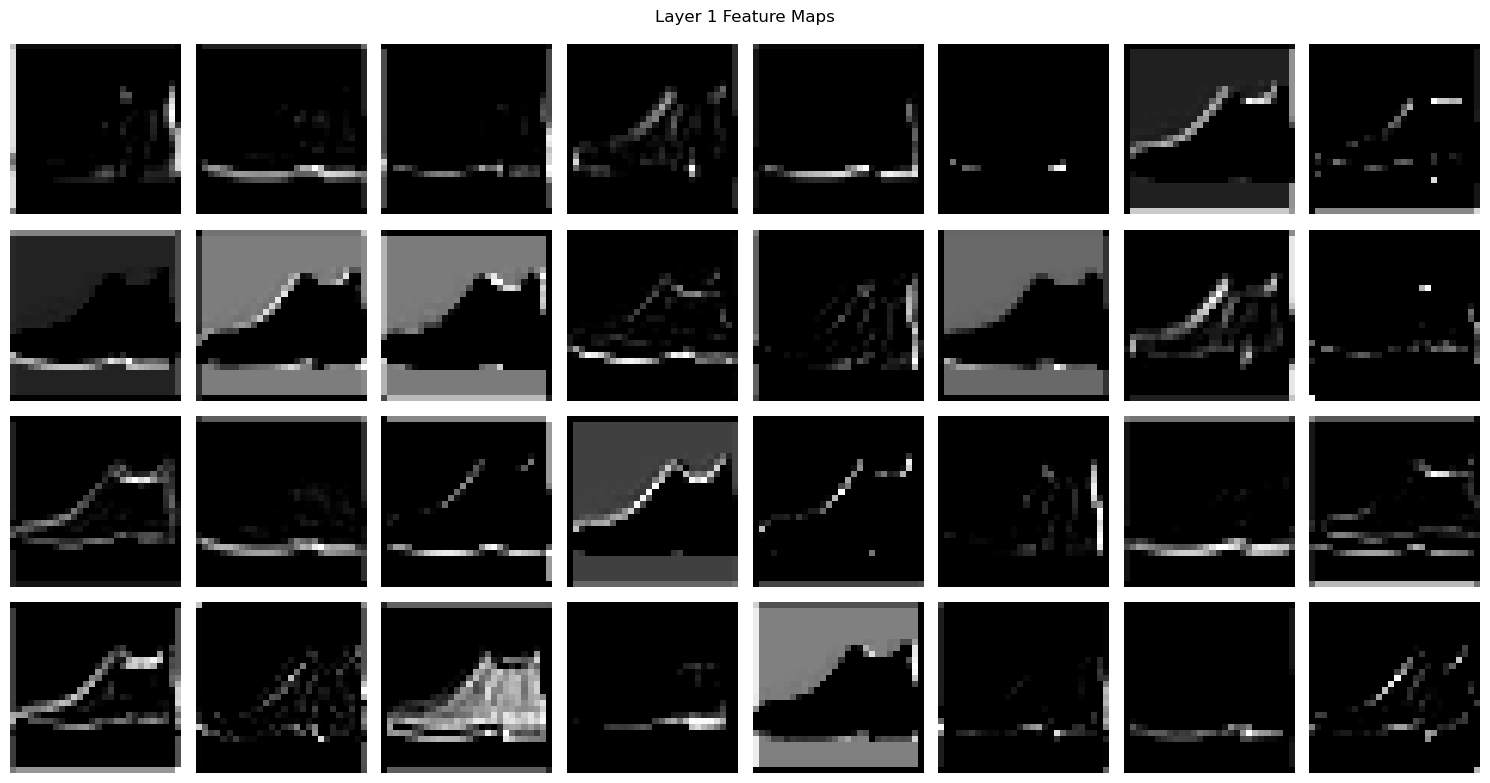

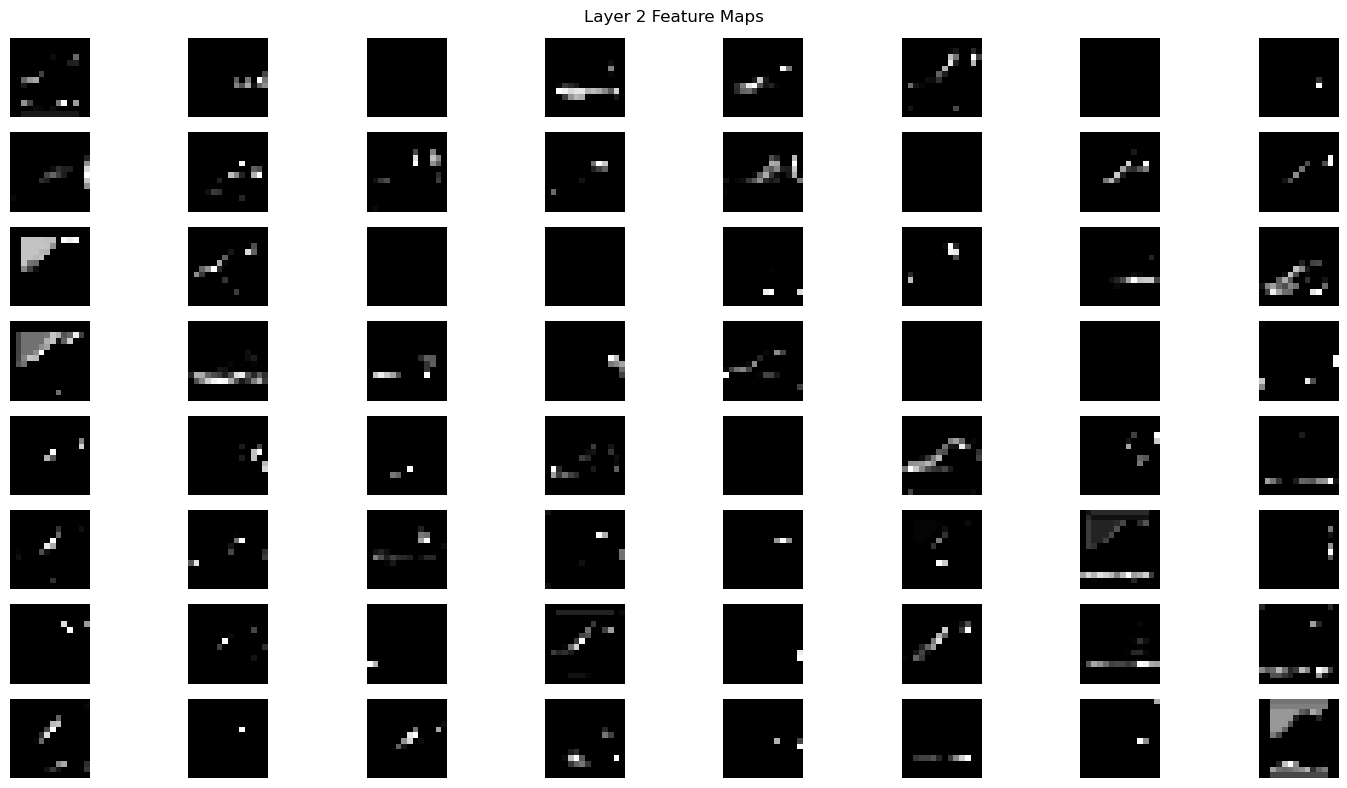

In [13]:
def visualize_intermediate_layers(image, model):
    """
    Visualizes intermediate convolutional feature maps from the CNN model.
    
    Parameters:
    - image: a single Fashion-MNIST image tensor (1 x 28 x 28), normalized
    - model: the trained CNN model
    """
    activations = []  # Store feature maps from different layers

    # Prepare the image for the model (add batch dimension)
    x = image.unsqueeze(0).to(next(model.parameters()).device)

    # Pass through first conv layer + ReLU
    x = model.conv1(x)
    x = torch.relu(x)
    activations.append(x)

    # Apply pooling
    x = model.pool(x)

    # Pass through second conv layer + ReLU
    x = model.conv2(x)
    x = torch.relu(x)
    activations.append(x)

    # Final pooling (not visualized)
    x = model.pool(x)

    # Plot feature maps from both conv layers
    for idx, activation in enumerate(activations):
        feature_maps = activation.detach().squeeze(0).cpu()  # Remove batch dimension and move to CPU
        num_maps = feature_maps.shape[0]
        n_columns = 8
        n_rows = (num_maps + n_columns - 1) // n_columns  # Compute number of rows

        fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
        fig.suptitle(f'Layer {idx+1} Feature Maps')

        # Flatten axs for easier indexing in case of 1 row
        axs = axs.flatten() if n_rows > 1 else [axs]

        for i in range(n_rows * n_columns):
            axs[i].axis('off')  # Hide all axes
            if i < num_maps:
                axs[i].imshow(feature_maps[i].numpy(), cmap='gray')  # Show feature map

        plt.tight_layout()
        plt.show()

# Example usage with a sample image from the test set
sample_image, _ = test_dataset[0]  # Load a sample image (normalized automatically)
visualize_intermediate_layers(sample_image, model)


above we can see the visualization for the feature maps on the first and second layer, giving us a bit more insight into how the network "sees" the features.

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3900       0.1000        2.3036  2.2269
      2        2.3040       0.1000        2.3036  1.8498
      3        2.3040       0.1000        2.3037  2.0566
      4        2.3040       0.1000        2.3037  2.0214
      5        2.3040       0.1000        2.3037  2.0493
      6        2.3040       0.1000        2.3037  2.0103
      7        2.3040       0.1000        2.3037  2.0236
      8        2.3040       0.1000        2.3037  2.1011
      9        2.3040       0.1000        2.3037  1.9498
     10        2.3040       0.1000        2.3037  2.0295
     11        2.3040       0.1000        2.3037  2.0176
     12        2.3040       0.1000        2.3037  2.0139
     13        2.3040       0.1000        2.3037  2.0088
     14        2.3040       0.1000        2.3037  2.0220
     15        2.3040       0.1000        2.3037  1.8360
     16        2.3040       0.1

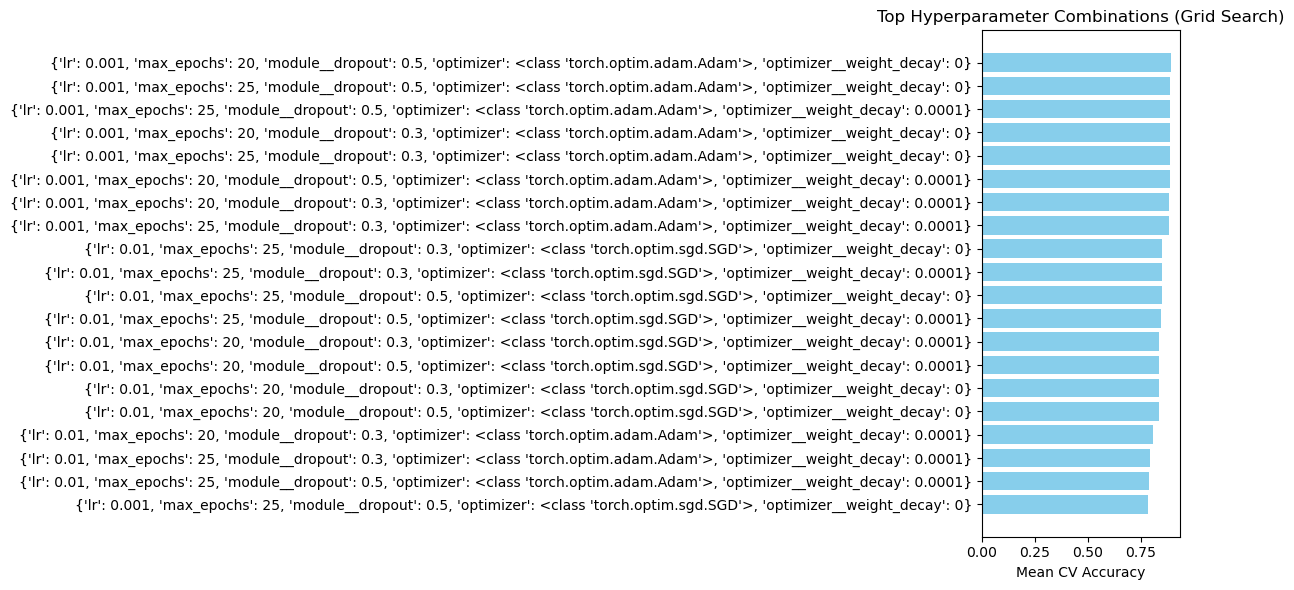

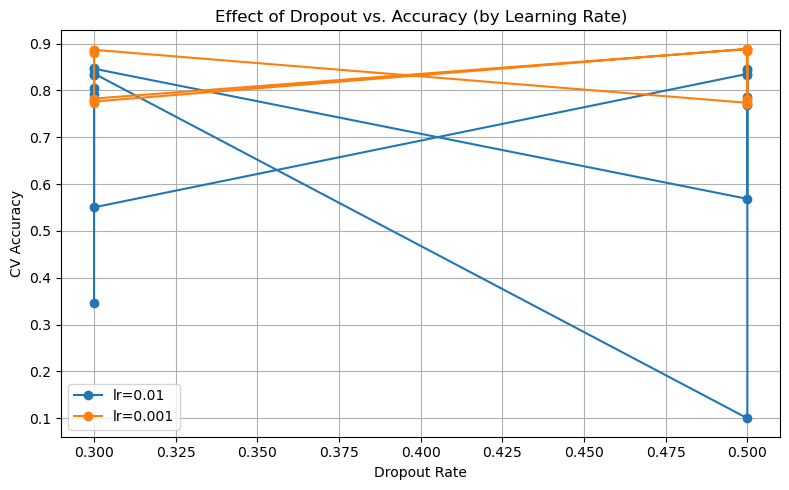

In [14]:
import pandas as pd
# Wrap the PyTorch CNN model in skorch's NeuralNetClassifier
net = NeuralNetClassifier(
    module=CNN,                      # Use the CNN class defined earlier
    max_epochs=25,                   # Maximum number of training epochs
    lr=0.01,                         # Initial learning rate
    optimizer=optim.Adam,           # Optimization algorithm
    criterion=nn.CrossEntropyLoss,  # Loss function for classification tasks
    batch_size=64,                  # Batch size for training
    device='cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
)

# Prepare Fashion-MNIST training data
# Extract the image tensors and convert to numpy arrays
X = [data[0].numpy() for data in train_dataset] 
X = np.array(X, dtype=np.float32)               # Convert list to NumPy array of float32
y = np.array([data[1] for data in train_dataset], dtype=np.int64)  # Labels to NumPy array

# Define a grid of hyperparameters to search over
params = {
    'lr': [0.01, 0.001],                        # Try different learning rates
    'max_epochs': [20, 25],                     # Vary number of epochs
    'module__dropout': [0.3, 0.5],              # Try different dropout rates in CNN
    'optimizer': [optim.Adam, optim.SGD],       # Try both Adam and SGD optimizers
    'optimizer__weight_decay': [0, 0.0001]  # Regularization strength
}

# Perform grid search with 3-fold cross-validation
gs = GridSearchCV(
    net,               # Base model to search over
    params,            # Hyperparameter grid
    refit=True,        # Refit best model on the full dataset after search
    cv=3,              # 3-fold cross-validation
    scoring='accuracy' # Use accuracy to score performance
)

# Fit model to the training data
gs.fit(X, y)

# Show best cross-validated score and corresponding hyperparameters
print('Best score:', gs.best_score_)
print('Best params:', gs.best_params_)

# Extract the best performing model from the grid search
best_net = gs.best_estimator_

# Prepare Fashion-MNIST test data for evaluation
X_test = [data[0].numpy() for data in test_dataset]     # Extract test images
X_test = np.array(X_test, dtype=np.float32)             # Convert to NumPy array
y_test = np.array([data[1] for data in test_dataset], dtype=np.int64)  # Extract labels

# === Visualization of Grid Search Results ===
# Convert results to DataFrame
results_df = pd.DataFrame(gs.cv_results_)

# Plot top N configurations
top_n = 20
top_results = results_df.sort_values(by='mean_test_score', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
plt.barh(range(top_n), top_results['mean_test_score'], color='skyblue')
plt.yticks(range(top_n), [str(x) for x in top_results['params']])
plt.xlabel('Mean CV Accuracy')
plt.title('Top Hyperparameter Combinations (Grid Search)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#visualize accuracy by specific hyperparameters (example: dropout)
plt.figure(figsize=(8, 5))
for lr in params['lr']:
    subset = results_df[results_df['param_lr'] == lr]
    plt.plot(subset['param_module__dropout'], subset['mean_test_score'], marker='o', label=f'lr={lr}')
plt.xlabel('Dropout Rate')
plt.ylabel('CV Accuracy')
plt.title('Effect of Dropout vs. Accuracy (by Learning Rate)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The best model performance (~88.9% accuracy) was achieved using a low learning rate (0.001), dropout of 0.5, and the Adam optimizer without weight decay. Overall, lower learning rates led to more stable and accurate results compared to higher ones. Dropout of 0.5 generally outperformed 0.3, indicating that stronger regularization helped reduce overfitting. Adam consistently outperformed SGD, and weight decay didn’t significantly improve performance. Lastly, increasing the number of epochs from 20 to 25 showed minimal gains, suggesting early convergence.

my main method for testing was trying to test all i could. i first wanted to test many more things in the hyper-parameters fine tuning, but sadly, doing so would lead to another 10-15 hours of running the code in the background, which is time which i sadly do not have.
ive found that despite the results we gain from our hyper-parameters fine tuning, the best result is still the default one we got, which sits at 92.75% accuracy, a whole 3 percent above the one we got here.
the main challange was, as ive said, mostly just waiting for the hyper-parameter fine tuning.